In [1]:
pip install tensorflow==2.15 xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 📦 Import dependencies
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# ===========================
# 1️⃣ LOAD ALL TRAINED MODELS
# ===========================
iforest = joblib.load("iforest_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")
lstm_model = tf.keras.models.load_model("lstm_model.h5")

# Load your test dataset
df = pd.read_csv("preprocessed_dataset_0510.csv", parse_dates=["timestamp"])

# ===========================
# 2️⃣ DEFINE FEATURES
# ===========================
FEATURES = [
    "cpu_usage", "memory_usage", "net_receive", "net_transmit",
    "fs_reads_bytes", "fs_writes_bytes", "restarts"
]

# Split into X and y
X = df[FEATURES].values
y_true = df["label"].values

# ===========================
# 3️⃣ STANDARD SCALING
# ===========================
scaler_standard = StandardScaler()
X_scaled = scaler_standard.fit_transform(X)

# For LSTM → use MinMaxScaler and reshape to 3D [samples, timesteps, features]
scaler_minmax = MinMaxScaler()
X_scaled_mm = scaler_minmax.fit_transform(X)

# Create sliding windows (use last 30 timesteps for each sample)
WINDOW_SIZE = 30
X_lstm = []
for i in range(len(X_scaled_mm) - WINDOW_SIZE):
    X_lstm.append(X_scaled_mm[i:i+WINDOW_SIZE])
X_lstm = np.array(X_lstm)

# Adjust true labels for LSTM alignment
y_lstm = y_true[WINDOW_SIZE:]

# ===========================
# 4️⃣ INDIVIDUAL MODEL PREDICTIONS
# ===========================

# Isolation Forest → predict() returns [-1, 1]
y_if = iforest.predict(X_scaled)
y_if = np.where(y_if == -1, 1, 0)  # convert to 1 = anomaly

# XGBoost
y_xgb = xgb_model.predict(X_scaled)

# LSTM
y_lstm_pred = (lstm_model.predict(X_lstm) > 0.5).astype("int32").flatten()

# Pad LSTM predictions to align with others
pad_length = len(y_true) - len(y_lstm_pred)
y_lstm_pred = np.pad(y_lstm_pred, (pad_length, 0), 'edge')

# ===========================
# 5️⃣ ENSEMBLE LOGIC
# ===========================
# Majority voting: at least 2 out of 3 predict anomaly → anomaly
ensemble_pred = (y_if + y_xgb + y_lstm_pred >= 2).astype(int)

# ===========================
# 6️⃣ EVALUATION
# ===========================
print("📊 Ensemble Classification Report:")
print(classification_report(y_true, ensemble_pred, digits=4))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_true, ensemble_pred))

# Optional: Save ensemble predictions
df["ensemble_pred"] = ensemble_pred
df.to_csv("ensemble_predictions.csv", index=False)
print("\n✅ Ensemble predictions saved to ensemble_predictions.csv")

2025-11-18 13:05:24.224633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-18 13:05:24.224677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-18 13:05:24.225794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-18 13:05:24.233460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 13:05:25.240673: W tensorflow/comp

12221/12221 [==============================] - 90s 7ms/step
📊 Ensemble Classification Report:
              precision    recall  f1-score   support

           0     0.9934    0.9945    0.9940    388059
           1     0.1796    0.1528    0.1651      3036

    accuracy                         0.9880    391095
   macro avg     0.5865    0.5737    0.5795    391095
weighted avg     0.9871    0.9880    0.9875    391095


📉 Confusion Matrix:
[[385939   2120]
 [  2572    464]]

✅ Ensemble predictions saved to ensemble_predictions.csv


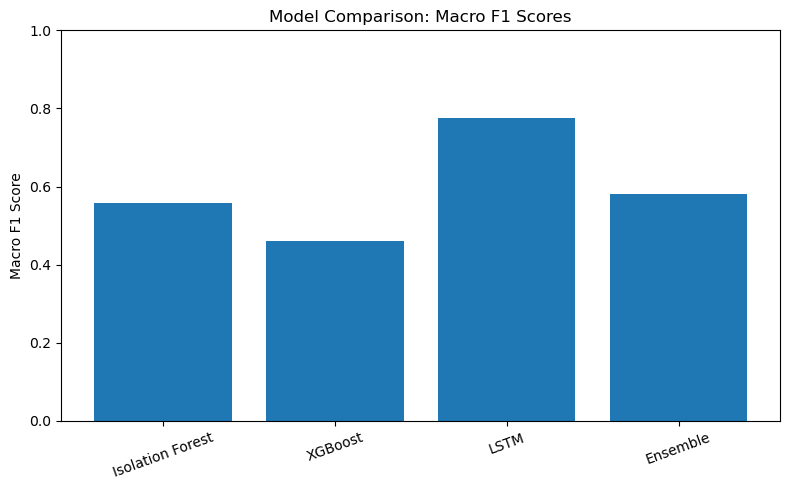

In [1]:
import matplotlib.pyplot as plt

# Macro-F1 values from your model reports
models = ["Isolation Forest", "XGBoost", "LSTM", "Ensemble"]
macro_f1 = [0.5567, 0.4601, 0.775, 0.5800]

plt.figure(figsize=(8,5))
plt.bar(models, macro_f1)
plt.ylabel("Macro F1 Score")
plt.title("Model Comparison: Macro F1 Scores")
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.tight_layout()

plt.show()